In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import zipfile
import os

In [3]:
extracted_path = 'D:/SLIIT/envs/projects/dta'

In [4]:
train_dir = os.path.join(extracted_path, 'train')
test_dir = os.path.join(extracted_path, 'test')

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    image_size = (48,48),
    batch_size = 128,
    shuffle = True,
    seed = 42
)

Found 28709 files belonging to 7 classes.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    image_size = (48,48),
    batch_size = 128,
    shuffle = True,
    seed = 42
)

Found 7178 files belonging to 7 classes.


In [7]:
val_ds = test_ds.take(len(test_ds)//2)
test_ds = test_ds.skip(len(test_ds)//2)

In [8]:
normalization = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization(x),y))
test_ds = test_ds.map(lambda x,y: (normalization(x),y))
val_ds = val_ds.map(lambda x,y: (normalization(x),y))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

In [10]:
import matplotlib.pyplot as plt

Batch images: (128, 48, 48, 1)
Batch labels: (128,)


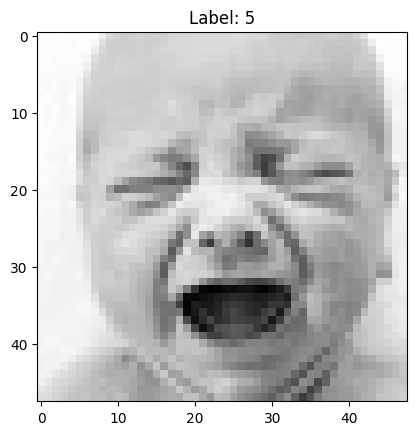

In [11]:
for images, labels in train_ds.take(1):
    print("Batch images:", images.shape)
    print("Batch labels:", labels.shape)
    plt.imshow(images[0].numpy().squeeze(), cmap="gray")
    plt.title(f"Label: {labels[0].numpy()}")
    plt.show()

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [13]:
train_ds_aug = train_ds.map(lambda x,y:(data_augmentation(x),y),num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
from collections import Counter

In [15]:
all_labels = np.concatenate([y.numpy() for x,y in train_ds], axis=0)
label_counts = Counter(all_labels)
num_classes = len(label_counts)
total = sum(label_counts.values())

class_weights = {i: total/(num_classes*count) for i, count in label_counts.items()}
print("Class weights:", class_weights)

Class weights: {np.int32(1): 9.406618610747051, np.int32(6): 1.293372978330405, np.int32(0): 1.0266046844269623, np.int32(3): 0.5684387684387684, np.int32(5): 0.8491274770777877, np.int32(2): 1.0010460615781582, np.int32(4): 0.8260394187886635}


In [16]:
train_ds_aug = train_ds_aug.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [17]:
from tensorflow.keras import layers,models

In [18]:
input_shape = (48, 48, 1)
num_classes = 7

In [19]:
def create_cnn(input_shape,num_classes):
  inputs = layers.Input(shape=input_shape)
  x = inputs

  # Block 1
  x = layers.Conv2D(32, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(32, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Dropout(0.25)(x)

  # Block 2
  x = layers.Conv2D(64, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(64, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Dropout(0.25)(x)

  # Block 3
  x = layers.Conv2D(128, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(128, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Dropout(0.25)(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.4)(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  model = models.Model(inputs, outputs, name="FER_CNN")
  return model

In [20]:
model = create_cnn(input_shape, num_classes)
model.summary()

Model: "FER_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 323,047 (1.23 MB)

 Trainable params: 322,151 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
ckpt = ModelCheckpoint("fer_cnn_best.keras", save_best_only=True, monitor="val_accuracy")
es = EarlyStopping(patience=8, restore_best_weights=True, monitor="val_accuracy")

In [24]:
history = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[ckpt, es]
)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 216s 929ms/step - accuracy: 0.1744 - loss: 1.9360 - val_accuracy: 0.1423 - val_loss: 2.0777
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 176s 779ms/step - accuracy: 0.2202 - loss: 1.8463 - val_accuracy: 0.1688 - val_loss: 2.2804
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 170s 755ms/step - accuracy: 0.2774 - loss: 1.7640 - val_accuracy: 0.1749 - val_loss: 1.9495
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 169s 748ms/step - accuracy: 0.3534 - loss: 1.6611 - val_accuracy: 0.2517 - val_loss: 1.9393
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 169s 749ms/step - accuracy: 0.3958 - loss: 1.5618 - val_accuracy: 0.4121 - val_loss: 1.5326
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 169s 749ms/step - accuracy: 0.4220 - loss: 1.5046 - val_accuracy: 0.4057 - val_loss: 1.5451
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.4394 - loss: 1.4574 - val_accuracy: 0.4263 - val_loss: 1.4755
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.4451 - loss:

In [25]:
val_metrics = model.evaluate(val_ds)
print("Validation set metrics:", dict(zip(model.metrics_names, val_metrics)))


test_metrics = model.evaluate(test_ds)
print("Test set metrics:", dict(zip(model.metrics_names, test_metrics)))

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.5530 - loss: 1.1915
Validation set metrics: {'loss': 1.1914825439453125, 'compile_metrics': 0.5530133843421936}
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.5743 - loss: 1.1435
Test set metrics: {'loss': 1.143506407737732, 'compile_metrics': 0.5742904543876648}


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━

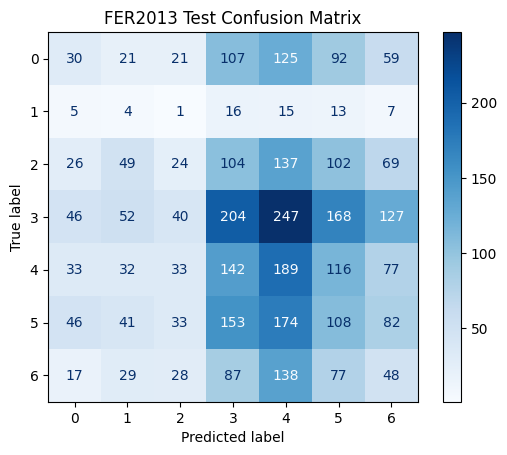

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = np.concatenate([model.predict(x) for x, y in test_ds], axis=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# display with default integer labels
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("FER2013 Test Confusion Matrix")
plt.show()